#Solving QUBOs with Qiskit-Optimization QAOA

Date: December 4th, 2023

The notebook contains materials supporting the tutorial paper:
*Five Starter Pieces: Solving QUBOs on Quantum Computers* by Arul Rhik Mazumder (arulm@andrew.cmu.edu) and Sridhar Tayur (stayur@cmu.edu).
It depends on various packages shown below.

### **Introduction**

OpenQAOA is multi-backend SDK used to easily implement QAOA circuits. It provides simple yet very detailed implementations of QAOA circuits that can not only run on IBMQ devices and simulators but also Rigetti Cloud Services, Amazon Braket, Microsoft Azure. The parent company of OpenQAOA also provide usage of their own custom simulators. Note that for resources like Rigetti, Braket, and Azure, the devices are only available with a subscription to their quantum services. Similar to Qiskit-Optimization, OpenQAOA can be used to generate custom problem QUBOs however these capabilities are neglected so the user can easily implement their own custom algorithms.

OpenQAOA is one of the best QAOA circuit SDKs availability not only because of the large range of applicable devices, but also the level of customizability and relevancy to ongoing research. OpenQAOA not only offers standard QAOA circuits but also recursive implementations RQAOA, as well as varied parametrization, initialization, and mixing strategies. OpenQAOA also offers a larger selection of optimizers than Qiskit-Optimization that are classified to three main categories: gradient-based, gradient-free, and shot-adaptive. Finally it is easy to plot data like optimization pathways or bitstring distributions using OpenQAOA. All these capabilities and workflows can be further explored in the link below:

https://openqaoa.entropicalabs.com/

Although OpenQAOA offers more optimizers than Qiskit-Optimization, however there list is still limited, and it is difficult to use custom optimizers. Furthermore similar to Qiskit-Optimization although you can adjust the circuit properties, you cannot directly modify the circuits also hindering the level of control.

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip install qiskit
  !pip install qiskit-optimization
  !pip install qiskit_aer
  !pip install openqaoa
  print("All Packages Installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 767.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671349 sha256=c7520e129ab2760f9bb195812638990c360e548c2062d6e6d75218c5c250dc65
  Stored in directory: /root/.cache/pip/wheels/3b/e5/00/0bf0173d67188fe73a13e3a6

All Packages Installed!


In [ ]:
# base qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from qiskit_optimization.converters import QuadraticProgramToQubo

# Misc. Imports
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Import the libraries needed to employ the QAOA quantum algorithm using OpenQAOA
from openqaoa import QAOA
from openqaoa.backends import create_device
from openqaoa.problems import NumberPartition, MaximumCut
from openqaoa.utilities import plot_graph

# method to convert a docplex model to a qubo problem
from docplex.mp.model import Model
from openqaoa.problems.converters import FromDocplex2IsingModel

### **Example 1 - Number Partitioning Problem**

Using OpenQAOA NumberPartition feature to generate a random array. This array is converted to the QUBO in the following step.

In [ ]:
prob = NumberPartition.random_instance(n_numbers=4)
qubo = prob.qubo
test = qubo.asdict()['problem_instance']['numbers']
arr = test
print(arr)
n = len(arr)
c = sum(arr)

[4, 9, 3, 8]


**Number Partitioning Models**

Given an array of $n$ integers $[a_{1}, a_{2}, a_{3} ... a_{n}]$, the corresponding Ising Hamiltonian is:

$$H=(\sum_{i=1}^{n}a_{i}s_{i})^2$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

Similarly the corresponding QUBO Model is:

$$Q=(\sum_{i=1}^{n}a_{i}-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$
or
$$Q=(c-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$

Where $c=\sum_{i=1}^{n}a_{i}$ and $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [ ]:
model = Model()
x = model.binary_var_list(n)
H = (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
model.minimize(H)

The QUBO Model is then converted to an Ising model to solve using QAOA.

In [ ]:
# Converting the Docplex model into its qubo representation
qubo = FromDocplex2IsingModel(model)

# Ising encoding of the QUBO problem
npp_ising = qubo.ising_model

-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0


**Solving the QUBO**

We then set multiple characteristics for the QAOA circuits, such as device, circuit properties, backend properties, and optimizer. In the example below, the backend is "qiskit.qasm_simulator", the number of diffuser and mixer layers is $2$, the number of shots is $1000$, and the optimizer is Cobyla with a maximum of $250$ iterations. Cobyla is one of the gradient independent optimizers provided by OpenQAOA.

In [ ]:
# initialize model
q = QAOA()

# device
q.set_device(create_device('local', 'qiskit.qasm_simulator'))

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q.set_backend_properties(n_shots = 1000)

# set optimizer and properties
q.set_classical_optimizer(maxiter=250, method='cobyla')

q.compile(npp_ising)

In [ ]:
#import time
start_time = time.time()
q.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

**Plotting the Results**

The resulting bitstrings are plotted in a histograms below.

Bitstrings with higher probabilites correspond to better solutions for the number partitioning problem.

states kept: 16


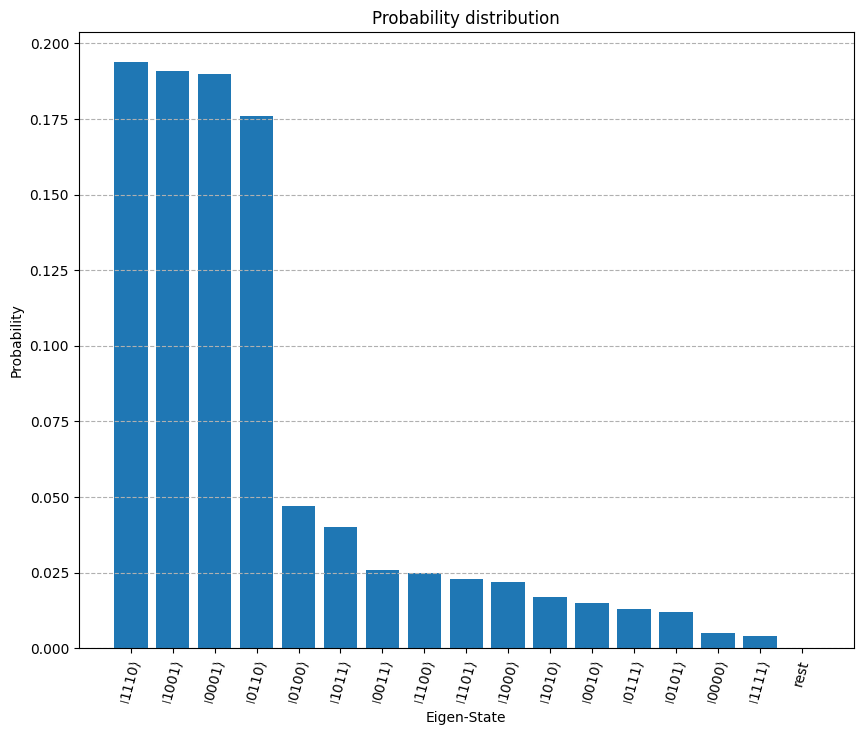

In [ ]:
q.result.plot_probabilities()

**Optimization Plot**

The bitstrings optimization pathway is shown below.

As shown, the bitstring cost starts off large however after more iterations of Cobyla, the corresponding cost decreases.

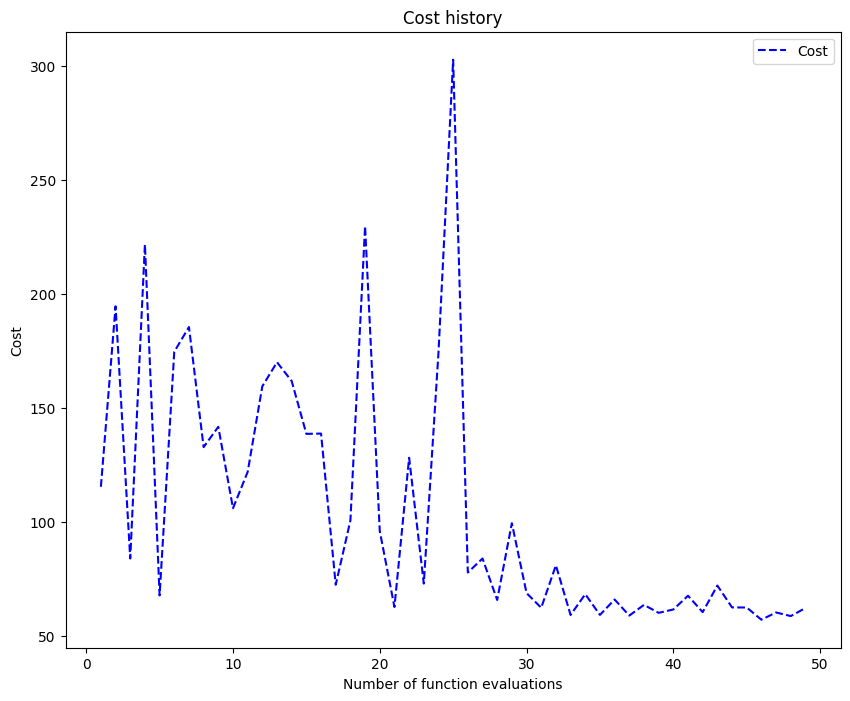

In [ ]:
q.result.plot_cost()

In [ ]:
# Converting the output binary variables to produce a valid output
def NPP_measure(solution, print=None):
    P1 = []
    P2 = []
    for i in range(len(solution)):
        if solution[i] == '0':
            P1.append(arr[i])
        else:
            P2.append(arr[i])
    sum1 = sum(P1[i] for i in range(len(P1)))
    sum2 = sum(P2[i] for i in range(len(P2)))
    if print:
      print("Partition 1:")
      print(P1)
      print('Sum: ' + str(sum1))
      print("Partition 2:")
      print(P2)
      print('Sum: ' + str(sum2))
    return abs(sum1 - sum2)

In [ ]:
solutions = q.result.most_probable_states['solutions_bitstrings']
print("Number of Solutions: " + str(len(solutions)))
sorted_solution = sorted(solutions, key=NPP_measure)
print("Optimization Time: " + str(elapsed_time))
NPP_measure(sorted_solution[0], print)

Number of Solutions: 1
Optimization Time: 0.9413051605224609
Partition 1:
[8]
Sum: 8
Partition 2:
[4, 9, 3]
Sum: 16


8

### **Example 2 - Max-Cut Problem**

Using OpenQAOA MaxCut feature to generate a random graph. This graph is converted to the QUBO in the following step.

In [ ]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

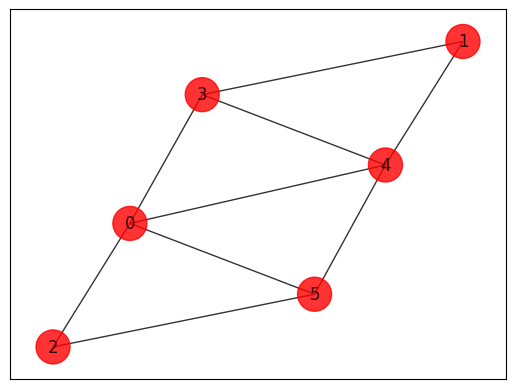

In [ ]:
G = nx.generators.fast_gnp_random_graph(n=6, p=0.5)
n = 6
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)

**Max-Cut Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=\sum_{(i, j) \in E}\frac{1-s_{i}s_{j}}{2}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

The corresponding QUBO Model is:

$$Q=\sum_{(i, j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [ ]:
model = Model()
x = model.binary_var_list(n)
H = sum(2*x[e[0]]*x[e[1]] - x[e[0]] - x[e[1]] for e in G.edges)
model.minimize(H)

In [ ]:
# Converting the Docplex model into its qubo representation
qubo = FromDocplex2IsingModel(model)

# Ising encoding of the QUBO problem
maxcut_ising = qubo.ising_model

-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0


**Solving the QUBO**

We then set multiple characteristics for the QAOA circuits, such as device, circuit properties, backend properties, and optimizer. In the example below, the backend is "vectorized", the number of diffuser and mixer layers is $2$, the number of shots is $1000$, and the optimizer is Vanilla Gradient Descent with a maximum of $250$ iterations. The gradient was computed using the finite difference method.

In [ ]:
# initialize model
q = QAOA()

# device
q.set_device(create_device('local', 'vectorized'))

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q.set_backend_properties(n_shots = 1000)

# set optimizer and properties
q.set_classical_optimizer(method='vgd', jac="finite_difference")

q.compile(maxcut_ising)

In [ ]:
#import time
start_time = time.time()
q.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

**Plotting the Results**

The resulting bitstrings are plotted in a histograms below.

Bitstrings with higher probabilites correspond to better solutions for the Max-Cut problem.

states kept: 40


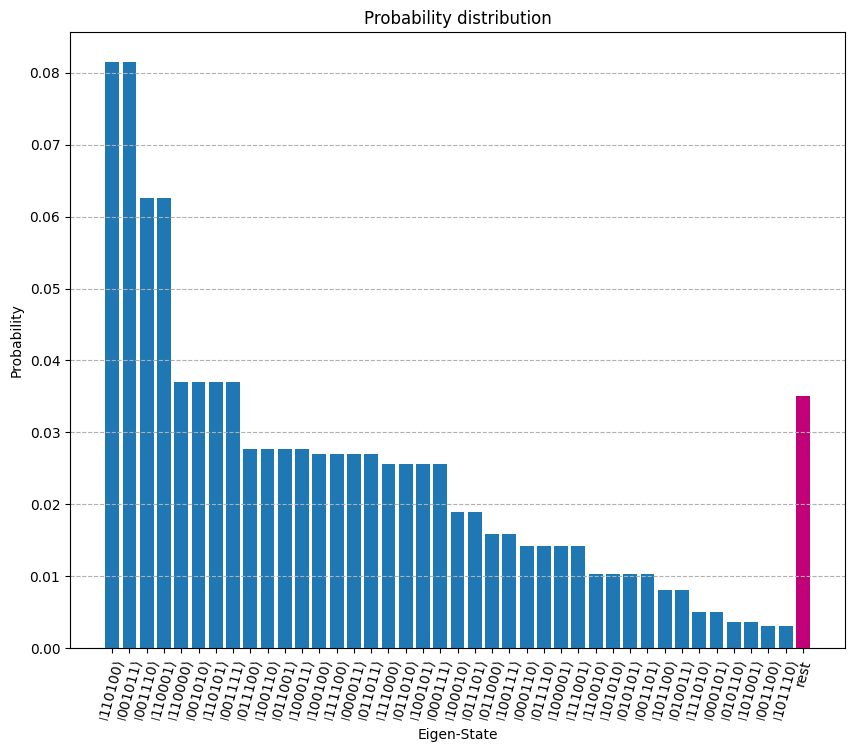

In [ ]:
q.result.plot_probabilities()

**Optimization Plot**

The bitstrings optimization pathway is shown below.

As shown, the bitstring cost starts off large however after more iterations of VGD, the corresponding cost decreases. Note that since VGD uses the gradient, the descent is smoother than gradient-free optimization techniques.

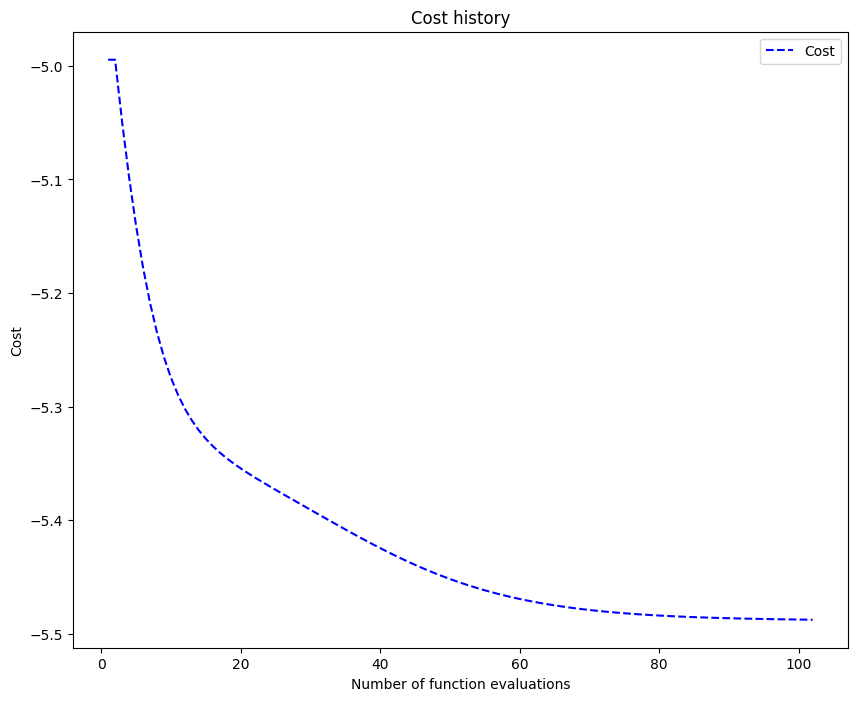

In [ ]:
q.result.plot_cost()

In [ ]:
# Converting the output binary variables to produce a valid output
def MaxCut_measure(solution, print=None):
  cut_size = 0
  for u, v in G.edges():
      if solution[u] != solution[v]:
          cut_size -= 1
  colors = ["r" if solution[i] == "0" else "c" for i in range(len(solution))]
  if print:
    draw_graph(G, colors, pos)
  return -cut_size

Number of Solutions: 2
Optimization Time: 3.720724105834961


5

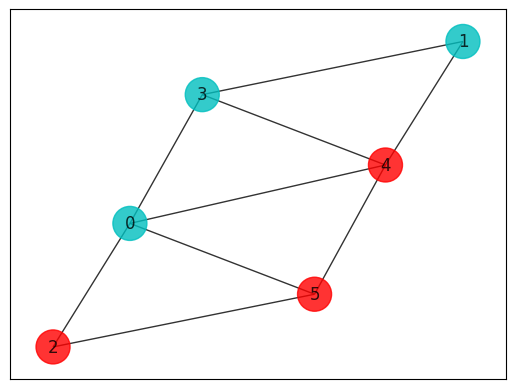

In [ ]:
solutions = q.result.most_probable_states['solutions_bitstrings']
print("Number of Solutions: " + str(len(solutions)))
sorted_solution = sorted(solutions, key=MaxCut_measure)
print("Optimization Time: " + str(elapsed_time))
MaxCut_measure(sorted_solution[0], print)

### **Example 3 - Minimum Vertex Cover**

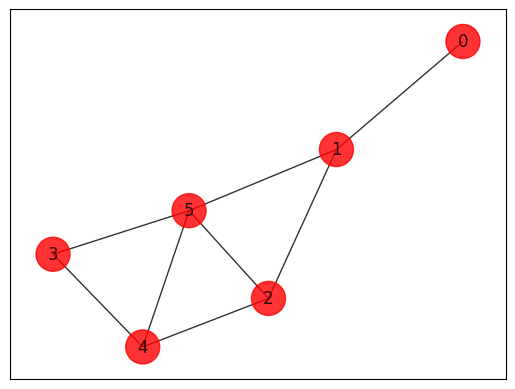

In [ ]:
G = nx.generators.fast_gnp_random_graph(n=6, p=0.5)
n=6
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)

**Minimum Vertex Cover Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ with vertices $i$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=P\sum_{(i, j) \in E}(1-s_{i})(1-s_{j}) + \sum_{i \in V}s_{i}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable and $P$ is the penalty coefficient.

The corresponding QUBO Model is:

$$Q=\sum_{i \in V}x_{i} + P(\sum_{(i, j) \in E}(1-x_{i}-x_{j}+x_{i}x_{j}))$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

Note in the example $P$ was chosen through trial-and-error although there exists rigorous mathematical processes

In [ ]:
model = Model()
x = model.binary_var_list(n)
P = 1
H = sum(x[i] for i in range(n)) + P*sum(1 - x[e[0]] - x[e[1]] + x[e[0]]*x[e[1]] for e in G.edges)
model.minimize(H)

In [ ]:
# Converting the Docplex model into its qubo representation
qubo = FromDocplex2IsingModel(model)

# Ising encoding of the QUBO problem
mvc_ising = qubo.ising_model

-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0


**Solving the QUBO**

We then set multiple characteristics for the QAOA circuits, such as device, circuit properties, backend properties, and optimizer. In the example below, the backend is "qiskit.shot_simulator", the number of diffuser and mixer layers is $2$, the number of shots is $1000$, and the optimizer is CANS (Coupled Adaptive Shots) with a maximum of $250$ iterations. This is an example of a shot-adaptive optimizer. Shot-adaptive optimizers take advantage of quantum computing to improve optimization. They do this by computing the gradient using varying numbers of shots which is chosen via some selection strategy.

In [ ]:
# initialize model
q = QAOA()

# device
q.set_device(create_device('local', 'qiskit.shot_simulator'))

# backend properties
q.set_backend_properties(n_shots = 1000)

# set optimizer and properties
q.set_classical_optimizer(method='cans', jac="param_shift", maxiter=100, optimizer_options=dict(stepsize=0.001, mu=0.95, b=0.001, n_shots_min=10, n_shots_max=100, n_shots_budget=50000))

q.compile(mvc_ising)

In [ ]:
#import time
start_time = time.time()
q.optimize()
end_time = time.time()
elapsed_time = end_time - start_time

/usr/local/lib/python3.10/dist-packages/openqaoa/derivatives/derivative_functions.py:633: RuntimeWarning: divide by zero encountered in double_scalars
  vect_eta[i] = np.pi / (4 * r)
/usr/local/lib/python3.10/dist-packages/openqaoa/qaoa_components/variational_parameters/extendedparams.py:108: RuntimeWarning: invalid value encountered in multiply
  return 2 * (self.cost_1q_coeffs * self.gammas_singles)


**Plotting the Results**

The resulting bitstrings are plotted in a histograms below.

Bitstrings with higher probabilites correspond to better solutions for the Minimum Vertex Cover problem.

states kept: 40


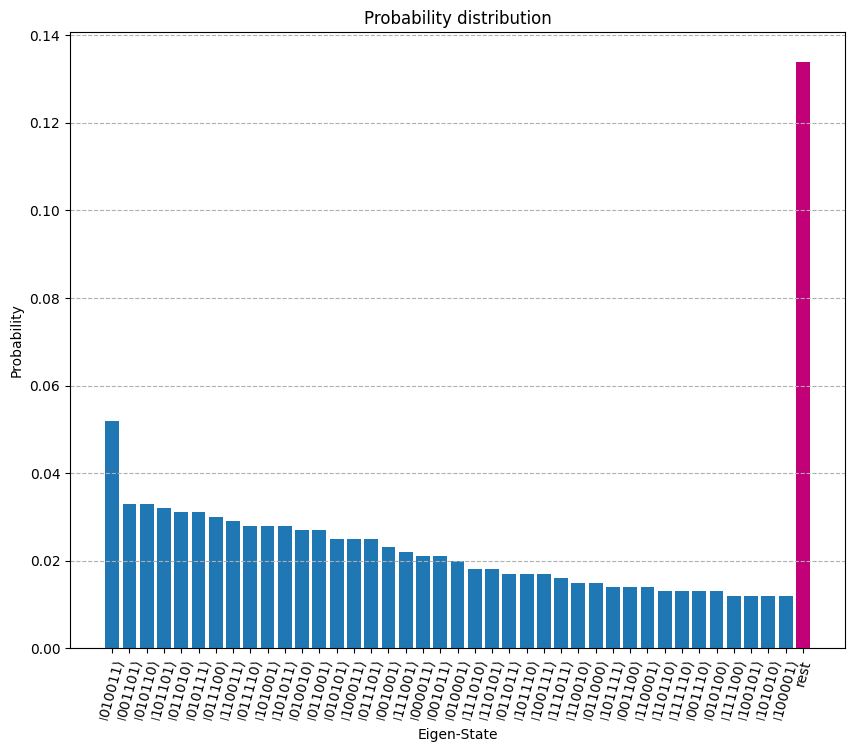

In [ ]:
q.result.plot_probabilities()

**Optimization Plot**

The bitstrings optimization pathway is shown below.

As shown, the bitstring cost starts off large however after more iterations of CANS, the corresponding cost decreases. Note the optimization path is not as clear as with the previous optimizers.

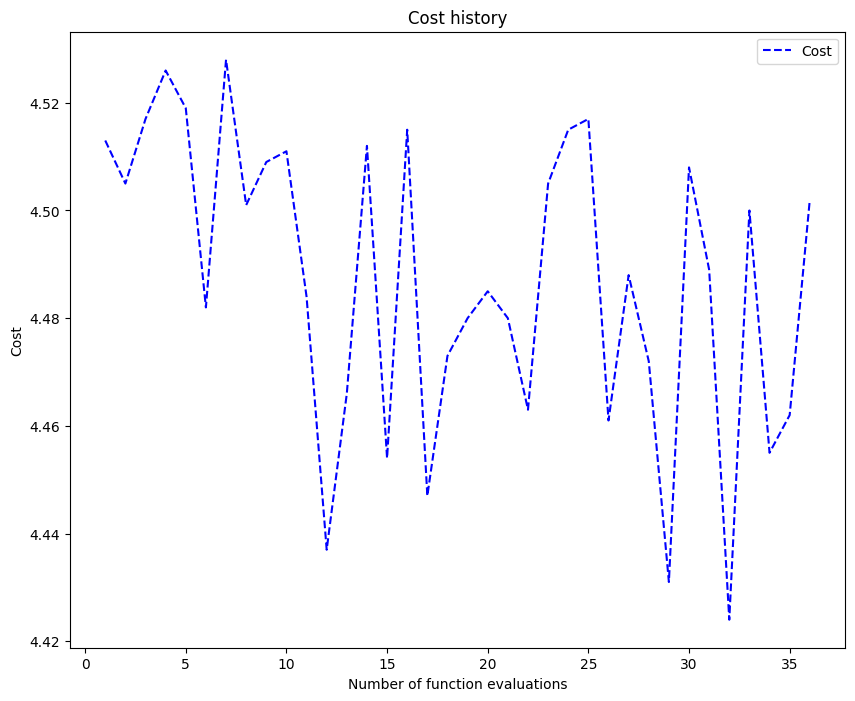

In [ ]:
q.result.plot_cost()

In [ ]:
# Converting the output binary variables to produce a valid output
def MVC_measure(solution, print=None):
  marked_edges = 0
  for u, v in G.edges():
    if solution[u] == "1" or solution[v] == "1":
      marked_edges -= 1
  num_marked = 0
  for i in range(len(solution)):
    if solution[i] == "1":
      num_marked += 1
  colors = ["r" if solution[i] == "0" else "c" for i in range(len(solution))]
  if print:
    draw_graph(G, colors, pos)
  return P*marked_edges+num_marked

Number of Solutions: 1
Optimization Time: 16.003926753997803


-5

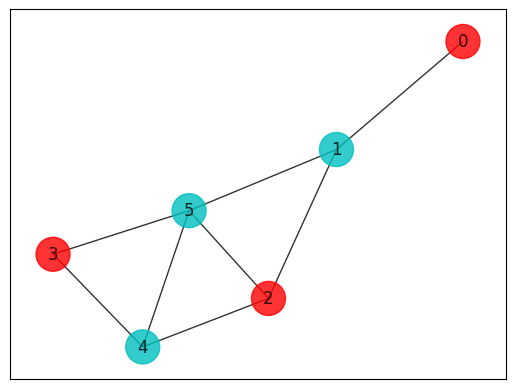

In [ ]:
solutions = q.result.most_probable_states['solutions_bitstrings']
print("Number of Solutions: " + str(len(solutions)))
sorted_solution = sorted(solutions, key=MVC_measure)
print("Optimization Time: " + str(elapsed_time))
MVC_measure(sorted_solution[0], print)